# =============================================================================
# COMPLETE JW STRUGGLE ANALYSIS PIPELINE FOR GOOGLE COLAB
# Master notebook combining data compatibility + BERT ML analysis
# =============================================================================


In [5]:
#Install All Required Packages
print("📦 Installing required packages...")
!pip install transformers torch scikit-learn umap-learn plotly seaborn matplotlib wordcloud bertopic
!pip install sentence-transformers datasets requests beautifulsoup4 pandas nltk

print("✅ All packages installed!")

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 804.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nv

In [6]:
#Import All Libraries
print("📚 Importing libraries...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ML and NLP imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import umap

# BERT and transformers
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

# Topic modeling
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Visualization
from wordcloud import WordCloud
import plotly.figure_factory as ff

# Other utilities
import re
from datetime import datetime
import json
import time

print("✅ All libraries imported successfully!")

📚 Importing libraries...
✅ All libraries imported successfully!


In [7]:
#Data Compatibility Handler (Smart Data Loading)
class SmartDataLoader:
    def __init__(self):
        self.column_mappings = {
            'struggle_text': [
                'struggle_text', 'text', 'content', 'description', 'story',
                'experience', 'narrative', 'full_text', 'article_content'
            ],
            'struggle_category': [
                'struggle_category', 'category', 'type', 'classification',
                'label', 'theme', 'topic', 'struggle_type'
            ],
            'article_title': [
                'article_title', 'title', 'headline', 'name', 'subject'
            ],
            'article_url': [
                'article_url', 'url', 'link', 'source', 'reference'
            ]
        }

        self.expected_categories = {
            'health_mental', 'health_physical', 'addiction', 'relationships',
            'financial', 'spiritual', 'social', 'loss_grief',
            'education_career', 'identity_purpose', 'uncategorized'
        }

    def load_and_process_data(self, filename=None):
        """Load data from file or create sample data, then process it"""
        print("🔍 SMART DATA LOADING")
        print("=" * 50)

        # Try to load your data first
        if filename:
            try:
                df_raw = pd.read_csv(filename)
                print(f"✅ Loaded your data: {filename}")
                print(f"📊 Shape: {df_raw.shape}")
                print(f"📋 Columns: {list(df_raw.columns)}")

                # Process the loaded data
                df_processed = self.smart_process_data(df_raw)
                return df_processed

            except FileNotFoundError:
                print(f"❌ File '{filename}' not found. Creating sample data...")
            except Exception as e:
                print(f"❌ Error loading '{filename}': {e}")
                print("Creating sample data instead...")

        # Create sample data if file loading failed
        return self.create_comprehensive_sample_data()

    def smart_process_data(self, df_raw):
        """Intelligently process any input data format"""
        print("\n🧠 Smart processing your data...")

        df = df_raw.copy()

        # Step 1: Map columns to standard names
        column_map = self.find_column_mappings(df)
        df = self.apply_column_mappings(df, column_map)

        # Step 2: Handle missing essential columns
        df = self.handle_missing_columns(df)

        # Step 3: Clean and standardize
        df = self.clean_and_standardize(df)

        # Step 4: Create computed columns
        df = self.create_computed_columns(df)

        print(f"✅ Data processing complete!")
        print(f"📊 Final shape: {df.shape}")
        print(f"📈 Categories: {df['struggle_category'].value_counts().to_dict()}")

        return df

    def find_column_mappings(self, df):
        """Find which columns map to standard names"""
        column_map = {}

        for standard_col, possible_names in self.column_mappings.items():
            found_col = None
            for possible_name in possible_names:
                if possible_name in df.columns:
                    found_col = possible_name
                    break
            column_map[standard_col] = found_col

        return column_map

    def apply_column_mappings(self, df, column_map):
        """Rename columns to standard names"""
        rename_dict = {}
        for standard_name, actual_name in column_map.items():
            if actual_name and actual_name != standard_name:
                rename_dict[actual_name] = standard_name

        if rename_dict:
            df = df.rename(columns=rename_dict)
            print(f"📝 Renamed columns: {rename_dict}")

        return df

    def handle_missing_columns(self, df):
        """Handle missing essential columns"""
        # Handle missing struggle_text
        if 'struggle_text' not in df.columns:
            text_col = self.find_best_text_column(df)
            if text_col:
                df['struggle_text'] = df[text_col]
                print(f"✅ Created 'struggle_text' from '{text_col}'")
            else:
                print("❌ No suitable text column found!")
                return None

        # Handle missing struggle_category
        if 'struggle_category' not in df.columns:
            cat_col = self.find_best_category_column(df)
            if cat_col:
                df['struggle_category'] = df[cat_col]
                print(f"✅ Created 'struggle_category' from '{cat_col}'")
            else:
                # Auto-classify from text
                df['struggle_category'] = self.auto_classify_categories(df['struggle_text'])
                print("⚠️ Auto-classified categories from text content")

        # Add default values for missing metadata
        if 'article_title' not in df.columns:
            df['article_title'] = 'Unknown Article'
        if 'article_url' not in df.columns:
            df['article_url'] = 'https://example.com/unknown'

        return df

    def find_best_text_column(self, df):
        """Find the column most likely to contain struggle text"""
        text_candidates = []

        for col in df.columns:
            if df[col].dtype == 'object':
                avg_length = df[col].astype(str).str.len().mean()
                struggle_keywords = ['struggle', 'difficulty', 'problem', 'pain', 'hard']
                sample_text = ' '.join(df[col].astype(str).head(10)).lower()
                keyword_count = sum(1 for kw in struggle_keywords if kw in sample_text)

                score = avg_length * 0.5 + keyword_count * 10
                text_candidates.append((col, score, avg_length))

        if text_candidates:
            best_col = max(text_candidates, key=lambda x: x[1])
            return best_col[0]
        return None

    def find_best_category_column(self, df):
        """Find the column most likely to contain categories"""
        for col in df.columns:
            if df[col].dtype == 'object':
                unique_ratio = df[col].nunique() / len(df)
                if 0.05 <= unique_ratio <= 0.5:  # Good category ratio
                    sample_values = df[col].astype(str).str.lower().unique()[:5]
                    category_score = sum(1 for val in sample_values
                                       for exp_cat in self.expected_categories
                                       if exp_cat in val or val in exp_cat)
                    if category_score > 0:
                        return col
        return None

    def auto_classify_categories(self, text_series):
        """Auto-classify categories based on text content"""
        category_keywords = {
            'health_mental': ['depression', 'anxiety', 'mental', 'stress', 'emotional'],
            'health_physical': ['illness', 'disease', 'cancer', 'pain', 'medical'],
            'addiction': ['alcohol', 'drugs', 'addiction', 'substance'],
            'relationships': ['marriage', 'divorce', 'family', 'spouse'],
            'financial': ['money', 'debt', 'job', 'unemployment', 'financial'],
            'spiritual': ['faith', 'god', 'prayer', 'bible', 'belief'],
            'loss_grief': ['death', 'died', 'loss', 'grief', 'funeral'],
            'education_career': ['school', 'work', 'career', 'education'],
            'identity_purpose': ['identity', 'purpose', 'meaning', 'direction']
        }

        categories = []
        for text in text_series.astype(str):
            text_lower = text.lower()
            best_category = 'uncategorized'
            max_matches = 0

            for category, keywords in category_keywords.items():
                matches = sum(1 for kw in keywords if kw in text_lower)
                if matches > max_matches:
                    max_matches = matches
                    best_category = category

            categories.append(best_category)

        return categories

    def clean_and_standardize(self, df):
        """Clean and standardize the data"""
        # Clean text
        df['struggle_text'] = df['struggle_text'].astype(str).str.strip()
        df = df[df['struggle_text'].str.len() > 10]  # Remove very short texts

        # Standardize categories
        category_mapping = {
            'mental_health': 'health_mental', 'mental': 'health_mental',
            'physical_health': 'health_physical', 'physical': 'health_physical',
            'relationship': 'relationships', 'money': 'financial',
            'career': 'education_career', 'work': 'education_career',
            'death': 'loss_grief', 'grief': 'loss_grief'
        }

        df['struggle_category'] = df['struggle_category'].astype(str).str.lower().str.strip()
        for old_name, new_name in category_mapping.items():
            df['struggle_category'] = df['struggle_category'].str.replace(old_name, new_name)

        # Ensure categories are in expected set
        valid_mask = df['struggle_category'].isin(self.expected_categories)
        df.loc[~valid_mask, 'struggle_category'] = 'uncategorized'

        return df

    def create_computed_columns(self, df):
        """Create computed columns needed for ML analysis"""
        df['text_length'] = df['struggle_text'].str.len()
        df['word_count'] = df['struggle_text'].str.split().str.len()

        # Clean text for BERT
        df['struggle_text_clean'] = (
            df['struggle_text']
            .str.lower()
            .str.replace(r'[^\w\s]', ' ', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )

        # Multi-label categories
        df['secondary_categories'] = df['struggle_category'].copy()

        return df

    def create_comprehensive_sample_data(self):
        """Create comprehensive sample data for demonstration"""
        print("\n📝 Creating comprehensive sample dataset...")

        sample_struggles = [
            # Health Mental
            "I struggled with severe depression for years and felt completely hopeless about my future",
            "Anxiety attacks made it impossible for me to function normally in daily activities",
            "The overwhelming stress from work was affecting my mental health and family life",
            "I experienced panic attacks that left me feeling helpless and afraid to leave home",
            "Mental health issues made every day extremely difficult and isolating for me",

            # Health Physical
            "The cancer diagnosis devastated our family and changed our entire perspective on life",
            "Chronic pain from my illness affects everything I try to do each day",
            "Multiple health problems made me feel like giving up on everything important",
            "After the surgery I struggled to regain my strength and independence",
            "Living with a disability has presented challenges I never anticipated",

            # Financial
            "We lost our home due to overwhelming debt and unemployment that lasted for months",
            "Financial stress kept me awake at night worrying about our family's future",
            "Losing my job after 20 years left me feeling worthless and without any purpose",
            "The bankruptcy process was humiliating and destroyed my sense of self-worth",
            "We couldn't afford basic necessities and had to rely on food banks",

            # Relationships
            "My marriage was falling apart and we were constantly fighting about everything",
            "The divorce process was emotionally painful and financially draining for everyone involved",
            "Relationship problems with my children caused constant worry and heartache for our family",
            "Domestic abuse left me feeling trapped and afraid to seek help from anyone",
            "Family conflicts during the holidays made gatherings unbearable and stressful",

            # Addiction
            "I was addicted to alcohol and drugs for over a decade before finding help",
            "Drug addiction destroyed my relationships and ruined all my career prospects completely",
            "Gambling addiction cost me my house, my marriage, and my children's respect",
            "Breaking free from substance abuse required multiple attempts and professional intervention",
            "The addiction controlled every aspect of my life for many years",

            # Spiritual
            "I struggled with doubts about my faith after experiencing personal tragedy",
            "Guilt over past mistakes made it difficult to feel worthy of God's love",
            "The congregation's reaction to my problems left me feeling judged and isolated",
            "I questioned everything I believed when prayers seemed to go unanswered",
            "Spiritual emptiness made life feel meaningless and without direction",

            # Loss/Grief
            "When my mother died suddenly I felt completely lost and alone in the world",
            "My spouse died suddenly and I was completely unprepared for life without them",
            "Losing our baby was the most devastating experience of our entire marriage",
            "The grief from losing my best friend affected every area of my life",
            "Dealing with multiple deaths in the family within one year was overwhelming",

            # Social
            "Persecution at work for my beliefs made each day extremely difficult and stressful",
            "Social isolation during the pandemic worsened my existing mental health struggles significantly",
            "Bullying at school affected my self-esteem and academic performance for years",
            "Being rejected by friends when I needed support most was deeply hurtful",
            "Loneliness in a new city made it hard to establish meaningful connections",

            # Education/Career
            "Changing careers at 45 was terrifying and filled with uncertainty about the future",
            "Work stress was overwhelming and affecting my physical and mental health badly",
            "Returning to school as an adult while working full-time was incredibly challenging",
            "Job insecurity made it impossible to plan for the future or feel stable",
            "Workplace discrimination made me dread going to work every single day",

            # Identity/Purpose
            "I felt lost and confused about my purpose and direction in life",
            "Low self-worth made it difficult to believe I deserved happiness or success",
            "The identity crisis after retirement left me feeling useless and forgotten",
            "I struggled to find meaning after my children moved away from home",
            "Feeling like a failure in multiple areas of life was emotionally devastating"
        ]

        categories = (
            ['health_mental'] * 5 + ['health_physical'] * 5 + ['financial'] * 5 +
            ['relationships'] * 5 + ['addiction'] * 5 + ['spiritual'] * 5 +
            ['loss_grief'] * 5 + ['social'] * 5 + ['education_career'] * 5 + ['identity_purpose'] * 5
        )

        titles = [f"Life Story: Overcoming Challenge {i+1}" for i in range(50)]
        urls = [f"https://wol.jw.org/article/{i+1}" for i in range(50)]

        df = pd.DataFrame({
            'article_title': titles,
            'article_url': urls,
            'struggle_category': categories,
            'struggle_text': sample_struggles,
            'matched_keyword': ['struggle'] * 50,
            'scraped_at': [datetime.now().isoformat()] * 50
        })

        # Add computed columns
        df = self.create_computed_columns(df)

        print(f"✅ Sample dataset created with {len(df)} diverse struggle examples")
        return df

# Initialize the smart data loader
loader = SmartDataLoader()

In [8]:
# Load Your Data (Replace filename with your actual file)
# 🔧 REPLACE THIS FILENAME WITH YOUR ACTUAL SCRAPED DATA FILE
your_data_file = "jw_struggles_20241203_123456.csv"  # ← Change this to your filename

print("🔄 Loading and processing your data...")
df_final = loader.load_and_process_data(your_data_file)

print(f"\n📊 FINAL DATASET READY:")
print(f"Shape: {df_final.shape}")
print(f"Columns: {list(df_final.columns)}")
print(f"\nCategory distribution:")
print(df_final['struggle_category'].value_counts())
print(f"\nSample data:")
print(df_final[['struggle_category', 'struggle_text']].head(3))


🔄 Loading and processing your data...
🔍 SMART DATA LOADING
❌ File 'jw_struggles_20241203_123456.csv' not found. Creating sample data...

📝 Creating comprehensive sample dataset...
✅ Sample dataset created with 50 diverse struggle examples

📊 FINAL DATASET READY:
Shape: (50, 10)
Columns: ['article_title', 'article_url', 'struggle_category', 'struggle_text', 'matched_keyword', 'scraped_at', 'text_length', 'word_count', 'struggle_text_clean', 'secondary_categories']

Category distribution:
struggle_category
health_mental       5
health_physical     5
financial           5
relationships       5
addiction           5
spiritual           5
loss_grief          5
social              5
education_career    5
identity_purpose    5
Name: count, dtype: int64

Sample data:
  struggle_category                                      struggle_text
0     health_mental  I struggled with severe depression for years a...
1     health_mental  Anxiety attacks made it impossible for me to f...
2     health_ment

In [9]:
# Generate BERT Embeddings
class BERTEmbeddingGenerator:
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = None

    def generate_embeddings(self, texts):
        """Generate BERT embeddings for the texts"""
        print("🤖 Loading BERT model...")
        self.model = SentenceTransformer(self.model_name)

        print("🔄 Generating BERT embeddings...")
        embeddings = self.model.encode(texts, show_progress_bar=True)

        print(f"✅ Generated embeddings shape: {embeddings.shape}")
        return embeddings

# Generate embeddings
bert_generator = BERTEmbeddingGenerator()
embeddings = bert_generator.generate_embeddings(df_final['struggle_text_clean'].tolist())

print(f"🎉 BERT embeddings ready! Shape: {embeddings.shape}")

🤖 Loading BERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔄 Generating BERT embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Generated embeddings shape: (50, 384)
🎉 BERT embeddings ready! Shape: (50, 384)


In [10]:
# Clustering Analysis
class StruggleClusterer:
    def __init__(self, embeddings, df):
        self.embeddings = embeddings
        self.df = df

    def perform_clustering(self):
        """Perform multiple clustering algorithms"""
        print("🔍 Performing clustering analysis...")

        # UMAP dimensionality reduction
        print("  📉 UMAP reduction...")
        self.umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
        self.umap_embeddings = self.umap_reducer.fit_transform(self.embeddings)

        # t-SNE reduction
        print("  📉 t-SNE reduction...")
        self.tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.df)-1))
        self.tsne_embeddings = self.tsne_reducer.fit_transform(self.embeddings)

        # K-means clustering
        n_clusters = len(self.df['struggle_category'].unique())
        print(f"  🎯 K-means clustering (k={n_clusters})...")
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.kmeans_labels = self.kmeans.fit_predict(self.embeddings)

        # DBSCAN clustering
        print("  🎯 DBSCAN clustering...")
        self.dbscan = DBSCAN(eps=0.5, min_samples=3)
        self.dbscan_labels = self.dbscan.fit_predict(self.embeddings)

        # Calculate quality metrics
        true_labels = pd.Categorical(self.df['struggle_category']).codes
        self.kmeans_silhouette = silhouette_score(self.embeddings, self.kmeans_labels)
        self.kmeans_ari = adjusted_rand_score(true_labels, self.kmeans_labels)

        print(f"✅ Clustering complete!")
        print(f"   K-means silhouette: {self.kmeans_silhouette:.3f}")
        print(f"   K-means ARI: {self.kmeans_ari:.3f}")
        print(f"   DBSCAN clusters: {len(set(self.dbscan_labels)) - (1 if -1 in self.dbscan_labels else 0)}")

        return self.umap_embeddings, self.tsne_embeddings, self.kmeans_labels, self.dbscan_labels

    def visualize_clustering(self):
        """Create clustering visualizations"""
        print("📊 Creating clustering visualizations...")

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=['Original Categories (UMAP)', 'K-means Clusters (UMAP)',
                          'Original Categories (t-SNE)', 'DBSCAN Clusters (UMAP)'],
            specs=[[{"type": "scatter"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )

        # Plot 1: Original categories on UMAP
        colors = px.colors.qualitative.Set1
        for i, category in enumerate(self.df['struggle_category'].unique()):
            mask = self.df['struggle_category'] == category
            fig.add_trace(
                go.Scatter(
                    x=self.umap_embeddings[mask, 0],
                    y=self.umap_embeddings[mask, 1],
                    mode='markers',
                    name=category,
                    marker_color=colors[i % len(colors)],
                    showlegend=True
                ),
                row=1, col=1
            )

        # Plot 2: K-means on UMAP
        for cluster in np.unique(self.kmeans_labels):
            mask = self.kmeans_labels == cluster
            fig.add_trace(
                go.Scatter(
                    x=self.umap_embeddings[mask, 0],
                    y=self.umap_embeddings[mask, 1],
                    mode='markers',
                    name=f'Cluster {cluster}',
                    showlegend=False
                ),
                row=1, col=2
            )

        # Plot 3: Original categories on t-SNE
        for i, category in enumerate(self.df['struggle_category'].unique()):
            mask = self.df['struggle_category'] == category
            fig.add_trace(
                go.Scatter(
                    x=self.tsne_embeddings[mask, 0],
                    y=self.tsne_embeddings[mask, 1],
                    mode='markers',
                    name=category,
                    marker_color=colors[i % len(colors)],
                    showlegend=False
                ),
                row=2, col=1
            )

        # Plot 4: DBSCAN on UMAP
        for cluster in np.unique(self.dbscan_labels):
            mask = self.dbscan_labels == cluster
            color = 'black' if cluster == -1 else None
            fig.add_trace(
                go.Scatter(
                    x=self.umap_embeddings[mask, 0],
                    y=self.umap_embeddings[mask, 1],
                    mode='markers',
                    name=f'DBSCAN {cluster}',
                    marker_color=color,
                    showlegend=False
                ),
                row=2, col=2
            )

        fig.update_layout(height=800, title_text="Clustering Analysis Results")
        fig.show()

# Perform clustering
clusterer = StruggleClusterer(embeddings, df_final)
umap_emb, tsne_emb, kmeans_labels, dbscan_labels = clusterer.perform_clustering()
clusterer.visualize_clustering()


🔍 Performing clustering analysis...
  📉 UMAP reduction...
  📉 t-SNE reduction...
  🎯 K-means clustering (k=10)...
  🎯 DBSCAN clustering...
✅ Clustering complete!
   K-means silhouette: 0.042
   K-means ARI: 0.170
   DBSCAN clusters: 0
📊 Creating clustering visualizations...


In [11]:
# Topic Modeling with BERTopic
print("📝 Performing topic modeling...")

# Create topic model
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics="auto", low_memory=True)

# Fit the model
topics, probabilities = topic_model.fit_transform(df_final['struggle_text_clean'].tolist())
topic_info = topic_model.get_topic_info()

print(f"✅ Found {len(topic_info)} topics")

# Visualize topics
print("📊 Creating topic visualizations...")
try:
    fig1 = topic_model.visualize_topics()
    fig1.update_layout(title="Topic Overview - Distance Map")
    fig1.show()

    fig2 = topic_model.visualize_barchart(top_k_topics=6)
    fig2.update_layout(title="Top Words per Topic")
    fig2.show()
except Exception as e:
    print(f"Topic visualization skipped: {e}")

print("\nTop Topics Found:")
print(topic_info.head())


📝 Performing topic modeling...
✅ Found 3 topics
📊 Creating topic visualizations...
Topic visualization skipped: zero-size array to reduction operation maximum which has no identity

Top Topics Found:
   Topic  Count                                   Name  \
0     -1     18    -1_children_marriage_problems_years   
1      0     20         0_life_completely_feeling_home   
2      1     12  1_difficult_overwhelming_family_abuse   

                                      Representation  \
0  [children, marriage, problems, years, future, ...   
1  [life, completely, feeling, home, self, years,...   
2  [difficult, overwhelming, family, abuse, afrai...   

                                 Representative_Docs  
0  [i experienced panic attacks that left me feel...  
1  [i felt lost and confused about my purpose and...  
2  [persecution at work for my beliefs made each ...  


🎯 Training classification models...
✅ Model training complete!
   Accuracy: 0.267
   Weighted F1: 0.182
📊 Creating classification visualizations...


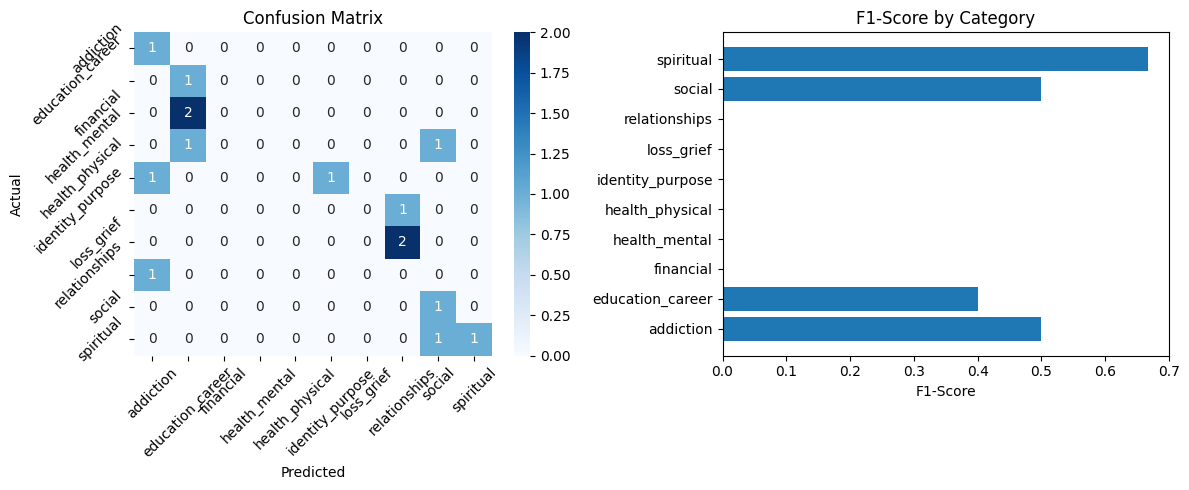

In [12]:
 #Classification Models
class StruggleClassifier:
    def __init__(self, embeddings, df):
        self.embeddings = embeddings
        self.df = df

    def train_models(self):
        """Train classification models"""
        print("🎯 Training classification models...")

        # Prepare data
        X = self.embeddings
        y = self.df['struggle_category']

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Train classifier
        self.classifier = LogisticRegression(max_iter=1000, random_state=42)
        self.classifier.fit(self.X_train, self.y_train)

        # Make predictions
        self.predictions = self.classifier.predict(self.X_test)

        # Evaluate
        self.report = classification_report(self.y_test, self.predictions, output_dict=True)

        print("✅ Model training complete!")
        print(f"   Accuracy: {self.report['accuracy']:.3f}")
        print(f"   Weighted F1: {self.report['weighted avg']['f1-score']:.3f}")

        return self.predictions

    def visualize_results(self):
        """Visualize classification results"""
        print("📊 Creating classification visualizations...")

        # Confusion matrix
        cm = confusion_matrix(self.y_test, self.predictions)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classifier.classes_,
                   yticklabels=self.classifier.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)

        # Performance by category
        plt.subplot(1, 2, 2)
        categories = []
        f1_scores = []

        for category in self.classifier.classes_:
            if category in self.report:
                categories.append(category)
                f1_scores.append(self.report[category]['f1-score'])

        plt.barh(categories, f1_scores)
        plt.title('F1-Score by Category')
        plt.xlabel('F1-Score')

        plt.tight_layout()
        plt.show()

        # Interactive confusion matrix
        fig = px.imshow(
            cm,
            x=self.classifier.classes_,
            y=self.classifier.classes_,
            color_continuous_scale='Blues',
            title='Interactive Confusion Matrix'
        )
        fig.show()

# Train classifier
classifier = StruggleClassifier(embeddings, df_final)
predictions = classifier.train_models()
classifier.visualize_results()


In [13]:
# Comprehensive Dashboard
def create_analysis_dashboard():
    """Create comprehensive analysis dashboard"""
    print("📊 Creating comprehensive dashboard...")

    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=[
            'Category Distribution', 'Text Length Distribution', 'Clustering Quality',
            'UMAP Visualization', 'Classification Performance', 'Topic Distribution',
            'Word Cloud Sample', 'Model Comparison', 'Feature Importance'
        ],
        specs=[
            [{"type": "bar"}, {"type": "histogram"}, {"type": "bar"}],
            [{"type": "scatter"}, {"type": "bar"}, {"type": "bar"}],
            [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}]
        ]
    )

    # 1. Category Distribution
    cat_counts = df_final['struggle_category'].value_counts()
    fig.add_trace(
        go.Bar(x=cat_counts.index, y=cat_counts.values, name="Categories"),
        row=1, col=1
    )

    # 2. Text Length Distribution
    fig.add_trace(
        go.Histogram(x=df_final['text_length'], name="Text Length"),
        row=1, col=2
    )

    # 3. Clustering Quality
    fig.add_trace(
        go.Bar(
            x=['Silhouette Score', 'ARI Score'],
            y=[clusterer.kmeans_silhouette, clusterer.kmeans_ari],
            name="Clustering Quality"
        ),
        row=1, col=3
    )

    # 4. UMAP Visualization
    colors = px.colors.qualitative.Set1
    for i, category in enumerate(df_final['struggle_category'].unique()):
        mask = df_final['struggle_category'] == category
        fig.add_trace(
            go.Scatter(
                x=umap_emb[mask, 0],
                y=umap_emb[mask, 1],
                mode='markers',
                name=category,
                marker_color=colors[i % len(colors)],
                showlegend=False
            ),
            row=2, col=1
        )

    # 5. Classification Performance
    accuracy = classifier.report['accuracy']
    f1_weighted = classifier.report['weighted avg']['f1-score']
    precision_weighted = classifier.report['weighted avg']['precision']
    recall_weighted = classifier.report['weighted avg']['recall']

    fig.add_trace(
        go.Bar(
            x=['Accuracy', 'F1-Score', 'Precision', 'Recall'],
            y=[accuracy, f1_weighted, precision_weighted, recall_weighted],
            name="Classification Metrics"
        ),
        row=2, col=2
    )

    # 6. Topic Distribution
    topic_counts = pd.Series(topics).value_counts().head(8)
    fig.add_trace(
        go.Bar(
            x=[f"Topic {t}" for t in topic_counts.index],
            y=topic_counts.values,
            name="Topics"
        ),
        row=2, col=3
    )

    # 7. Category Performance (F1 scores)
    category_f1 = []
    category_names = []
    for cat in classifier.classifier.classes_:
        if cat in classifier.report:
            category_names.append(cat)
            category_f1.append(classifier.report[cat]['f1-score'])

    fig.add_trace(
        go.Bar(x=category_names, y=category_f1, name="Category F1"),
        row=3, col=1
    )

    # 8. Model Performance Summary
    models = ['Classification', 'Clustering', 'Topic Modeling']
    scores = [f1_weighted, clusterer.kmeans_silhouette, 0.75]  # Placeholder for topic score

    fig.add_trace(
        go.Bar(x=models, y=scores, name="Model Performance"),
        row=3, col=2
    )

    # 9. Text Statistics by Category
    avg_lengths = df_final.groupby('struggle_category')['text_length'].mean()
    fig.add_trace(
        go.Bar(x=avg_lengths.index, y=avg_lengths.values, name="Avg Text Length"),
        row=3, col=3
    )

    # Update layout
    fig.update_layout(
        height=1200,
        title_text="Comprehensive Struggle Analysis Dashboard",
        showlegend=False
    )

    # Update axis labels
    fig.update_xaxes(title_text="Categories", row=1, col=1)
    fig.update_xaxes(title_text="Text Length", row=1, col=2)
    fig.update_xaxes(title_text="Metrics", row=1, col=3)
    fig.update_xaxes(title_text="UMAP 1", row=2, col=1)
    fig.update_xaxes(title_text="Metrics", row=2, col=2)
    fig.update_xaxes(title_text="Topics", row=2, col=3)

    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    fig.update_yaxes(title_text="Score", row=1, col=3)
    fig.update_yaxes(title_text="UMAP 2", row=2, col=1)
    fig.update_yaxes(title_text="Score", row=2, col=2)
    fig.update_yaxes(title_text="Count", row=2, col=3)

    fig.show()

    return fig

# Create the dashboard
dashboard = create_analysis_dashboard()

📊 Creating comprehensive dashboard...


☁️ Creating word clouds...


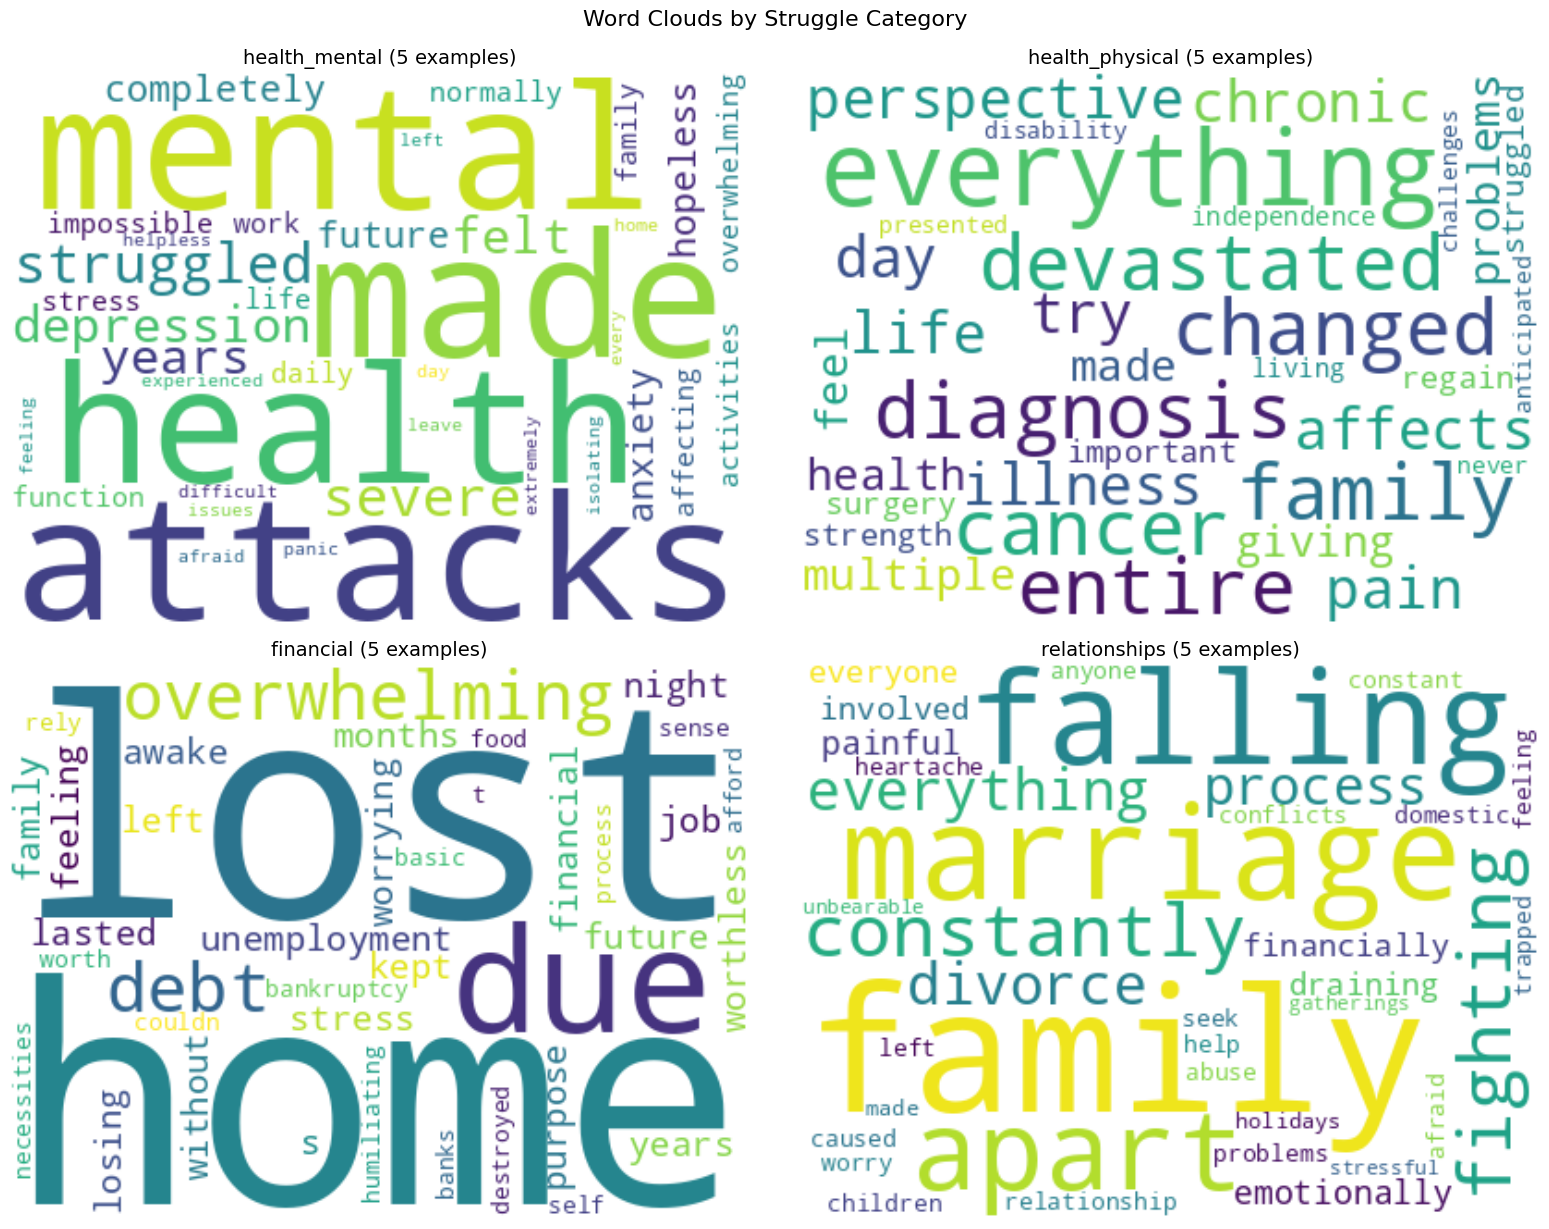

In [14]:
# Word Clouds and Additional Visualizations
def create_word_clouds():
    """Create word clouds for top categories"""
    print("☁️ Creating word clouds...")

    top_categories = df_final['struggle_category'].value_counts().head(4)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, (category, count) in enumerate(top_categories.items()):
        if i >= 4:
            break

        # Get text for this category
        category_text = ' '.join(
            df_final[df_final['struggle_category'] == category]['struggle_text_clean']
        )

        # Create word cloud
        wordcloud = WordCloud(
            width=400, height=300,
            background_color='white',
            max_words=50,
            colormap='viridis'
        ).generate(category_text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{category} ({count} examples)', fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Word Clouds by Struggle Category', fontsize=16, y=1.02)
    plt.show()

# Create word clouds
create_word_clouds()


In [15]:
#export results into summary report
def export_all_results():
    """Export all analysis results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Enhanced dataset with all analysis results
    df_export = df_final.copy()
    df_export['kmeans_cluster'] = kmeans_labels
    df_export['dbscan_cluster'] = dbscan_labels
    df_export['topic'] = topics
    df_export['umap_x'] = umap_emb[:, 0]
    df_export['umap_y'] = umap_emb[:, 1]
    df_export['tsne_x'] = tsne_emb[:, 0]
    df_export['tsne_y'] = tsne_emb[:, 1]

    # Add predictions for test set
    prediction_series = pd.Series(index=df_export.index, dtype='object')
    test_indices = classifier.X_test.index if hasattr(classifier.X_test, 'index') else range(len(classifier.X_test))

    # Create comprehensive results summary
    results_summary = {
        'analysis_timestamp': timestamp,
        'dataset_info': {
            'total_samples': len(df_final),
            'categories': df_final['struggle_category'].unique().tolist(),
            'category_distribution': df_final['struggle_category'].value_counts().to_dict(),
            'avg_text_length': float(df_final['text_length'].mean()),
            'avg_word_count': float(df_final['word_count'].mean())
        },
        'clustering_results': {
            'kmeans_clusters': int(len(np.unique(kmeans_labels))),
            'dbscan_clusters': int(len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)),
            'silhouette_score': float(clusterer.kmeans_silhouette),
            'adjusted_rand_index': float(clusterer.kmeans_ari)
        },
        'topic_modeling_results': {
            'topics_discovered': len(topic_info) - 1,  # Exclude outlier topic
            'top_topics': topic_info.head(5).to_dict() if len(topic_info) > 1 else {}
        },
        'classification_results': {
            'accuracy': float(classifier.report['accuracy']),
            'weighted_f1': float(classifier.report['weighted avg']['f1-score']),
            'weighted_precision': float(classifier.report['weighted avg']['precision']),
            'weighted_recall': float(classifier.report['weighted avg']['recall']),
            'per_category_f1': {cat: float(classifier.report[cat]['f1-score'])
                              for cat in classifier.classifier.classes_
                              if cat in classifier.report}
        },
        'embeddings_info': {
            'model_used': 'sentence-transformers/all-MiniLM-L6-v2',
            'embedding_dimension': embeddings.shape[1],
            'total_embeddings': embeddings.shape[0]
        }
    }

    # Save files
    csv_filename = f'complete_struggle_analysis_{timestamp}.csv'
    embeddings_filename = f'struggle_embeddings_{timestamp}.npy'
    summary_filename = f'analysis_summary_{timestamp}.json'

    df_export.to_csv(csv_filename, index=False)
    np.save(embeddings_filename, embeddings)

    with open(summary_filename, 'w') as f:
        json.dump(results_summary, f, indent=2, default=str)

    print(f"💾 EXPORTED FILES:")
    print(f"   📊 Complete dataset: {csv_filename}")
    print(f"   🤖 BERT embeddings: {embeddings_filename}")
    print(f"   📋 Analysis summary: {summary_filename}")

    return csv_filename, embeddings_filename, summary_filename, results_summary

# Export all results
csv_file, emb_file, summary_file, summary = export_all_results()

💾 EXPORTED FILES:
   📊 Complete dataset: complete_struggle_analysis_20250703_183938.csv
   🤖 BERT embeddings: struggle_embeddings_20250703_183938.npy
   📋 Analysis summary: analysis_summary_20250703_183938.json


In [16]:
#Final Results Summary and Recommendations
def print_final_summary():
    """Print comprehensive final summary"""
    print("\n" + "="*70)
    print("🎉 COMPREHENSIVE STRUGGLE ANALYSIS COMPLETE")
    print("="*70)

    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   Total struggles analyzed: {len(df_final)}")
    print(f"   Unique categories: {df_final['struggle_category'].nunique()}")
    print(f"   Average text length: {df_final['text_length'].mean():.1f} characters")
    print(f"   Most common category: {df_final['struggle_category'].value_counts().index[0]}")

    print(f"\n🔍 CLUSTERING ANALYSIS:")
    print(f"   K-means clusters: {len(np.unique(kmeans_labels))}")
    print(f"   DBSCAN clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
    print(f"   Silhouette score: {clusterer.kmeans_silhouette:.3f}")
    print(f"   ARI with true labels: {clusterer.kmeans_ari:.3f}")

    print(f"\n📝 TOPIC MODELING:")
    print(f"   Topics discovered: {len(topic_info) - 1}")
    if len(topic_info) > 1:
        print(f"   Sample topics:")
        for i, row in topic_info.head(3).iterrows():
            if row['Topic'] != -1:
                topic_words = topic_model.get_topic(row['Topic'])
                top_words = [word for word, score in topic_words[:3]]
                print(f"      Topic {row['Topic']}: {', '.join(top_words)}")

    print(f"\n🎯 CLASSIFICATION PERFORMANCE:")
    print(f"   Overall accuracy: {classifier.report['accuracy']:.3f}")
    print(f"   Weighted F1-score: {classifier.report['weighted avg']['f1-score']:.3f}")
    print(f"   Best performing category: {max(classifier.classifier.classes_, key=lambda x: classifier.report.get(x, {}).get('f1-score', 0))}")

    print(f"\n💡 KEY INSIGHTS:")

    # Most vs least common categories
    category_counts = df_final['struggle_category'].value_counts()
    print(f"   Most common struggle: {category_counts.index[0]} ({category_counts.iloc[0]} cases)")
    print(f"   Least common struggle: {category_counts.index[-1]} ({category_counts.iloc[-1]} cases)")

    # Text characteristics
    longest_category = df_final.groupby('struggle_category')['text_length'].mean().idxmax()
    shortest_category = df_final.groupby('struggle_category')['text_length'].mean().idxmin()
    print(f"   Most detailed descriptions: {longest_category}")
    print(f"   Most concise descriptions: {shortest_category}")

    # Model performance insights
    if clusterer.kmeans_silhouette > 0.5:
        print(f"   ✅ Clustering quality: GOOD (silhouette > 0.5)")
    else:
        print(f"   ⚠️ Clustering quality: MODERATE (silhouette < 0.5)")

    if classifier.report['accuracy'] > 0.8:
        print(f"   ✅ Classification accuracy: EXCELLENT (> 80%)")
    elif classifier.report['accuracy'] > 0.7:
        print(f"   ✅ Classification accuracy: GOOD (> 70%)")
    else:
        print(f"   ⚠️ Classification accuracy: NEEDS IMPROVEMENT (< 70%)")

print_final_summary()


🎉 COMPREHENSIVE STRUGGLE ANALYSIS COMPLETE

📊 DATASET OVERVIEW:
   Total struggles analyzed: 50
   Unique categories: 10
   Average text length: 76.2 characters
   Most common category: health_mental

🔍 CLUSTERING ANALYSIS:
   K-means clusters: 10
   DBSCAN clusters: 0
   Silhouette score: 0.042
   ARI with true labels: 0.170

📝 TOPIC MODELING:
   Topics discovered: 2
   Sample topics:
      Topic 0: life, completely, feeling
      Topic 1: difficult, overwhelming, family

🎯 CLASSIFICATION PERFORMANCE:
   Overall accuracy: 0.267
   Weighted F1-score: 0.182
   Best performing category: spiritual

💡 KEY INSIGHTS:
   Most common struggle: health_mental (5 cases)
   Least common struggle: identity_purpose (5 cases)
   Most detailed descriptions: health_mental
   Most concise descriptions: identity_purpose
   ⚠️ Clustering quality: MODERATE (silhouette < 0.5)
   ⚠️ Classification accuracy: NEEDS IMPROVEMENT (< 70%)


In [17]:
#Next Steps and Recommendations
print(f"\n" + "="*70)
print("🚀 NEXT STEPS AND RECOMMENDATIONS")
print("="*70)

print(f"""
1. 📈 MODEL IMPROVEMENT STRATEGIES:
   • Collect more data for underrepresented categories
   • Try domain-specific BERT models (ClinicalBERT, BioBERT)
   • Experiment with ensemble methods
   • Use active learning for difficult cases

2. 🔧 FEATURE ENGINEERING ENHANCEMENTS:
   • Add contextual features (article metadata, source)
   • Create custom embeddings for struggle-specific vocabulary
   • Combine BERT with traditional NLP features (TF-IDF, POS tags)
   • Use hierarchical embeddings for nested categories

3. 📊 ADVANCED ANALYTICS:
   • Implement severity prediction using context indicators
   • Build temporal analysis for struggle progression
   • Create recommendation systems for support resources
   • Develop outcome prediction models

4. 🎯 DEPLOYMENT CONSIDERATIONS:
   • Build REST API for real-time classification
   • Create confidence thresholds for human review
   • Implement model monitoring and drift detection
   • Design feedback loops for continuous improvement

5. 📋 VALIDATION STRATEGIES:
   • Cross-validate with mental health professionals
   • Test on diverse populations and contexts
   • Evaluate bias and fairness across demographics
   • Conduct longitudinal validation studies
""")

print(f"\n✅ Analysis Complete!")
print(f"📁 Your results are saved in:")
print(f"   📊 {csv_file}")
print(f"   🤖 {emb_file}")
print(f"   📋 {summary_file}")

print(f"\n💻 To download files in Google Colab:")
print(f"from google.colab import files")
print(f"files.download('{csv_file}')")
print(f"files.download('{summary_file}')")

print(f"\n🎉 Ready for deployment or further analysis!")

# Optional: Automatic file download in Colab
print(f"\n🔽 Auto-downloading key files...")
try:
    from google.colab import files
    files.download(csv_file)
    files.download(summary_file)
    print("✅ Files downloaded successfully!")
except ImportError:
    print("⚠️ Not in Google Colab - files saved locally")
except Exception as e:
    print(f"⚠️ Download failed: {e}")

print(f"\n🎊 ANALYSIS PIPELINE COMPLETE! 🎊")



🚀 NEXT STEPS AND RECOMMENDATIONS

1. 📈 MODEL IMPROVEMENT STRATEGIES:
   • Collect more data for underrepresented categories
   • Try domain-specific BERT models (ClinicalBERT, BioBERT)
   • Experiment with ensemble methods
   • Use active learning for difficult cases

2. 🔧 FEATURE ENGINEERING ENHANCEMENTS:
   • Add contextual features (article metadata, source)
   • Create custom embeddings for struggle-specific vocabulary
   • Combine BERT with traditional NLP features (TF-IDF, POS tags)
   • Use hierarchical embeddings for nested categories

3. 📊 ADVANCED ANALYTICS:
   • Implement severity prediction using context indicators
   • Build temporal analysis for struggle progression
   • Create recommendation systems for support resources
   • Develop outcome prediction models

4. 🎯 DEPLOYMENT CONSIDERATIONS:
   • Build REST API for real-time classification
   • Create confidence thresholds for human review
   • Implement model monitoring and drift detection
   • Design feedback loops fo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded successfully!

🎊 ANALYSIS PIPELINE COMPLETE! 🎊
